In [14]:
from langgraph.graph import StateGraph, START, END
from dotenv import load_dotenv
import os
from typing import TypedDict, Annotated
from pydantic import BaseModel, Field
from langchain_google_genai import ChatGoogleGenerativeAI
import operator

In [3]:
load_dotenv()

True

In [6]:
model = ChatGoogleGenerativeAI(model='gemini-2.5-flash', temperature = 0)

To have structured output, we'll create a structure/schema


In [7]:
class EvaluationSchema(BaseModel):

    feedback: str = Field(description="Detailed feedback for the essay")
    score: int = Field(description="Scrore out of 10", ge=0, le=10)
    

In [8]:
structured_model = model.with_structured_output(EvaluationSchema)

In [10]:
essay = """Role of AI in Modern Education

There is no denying that Artificial Intelligence (AI) has become an integral part of our daily lives, transforming various sectors including education. The integration of AI in modern education has brought about significant changes in the way students learn and teachers teach. AI-powered tools and platforms have made personalized learning a reality, allowing students to learn at their own pace and style. Intelligent tutoring systems can adapt to the individual needs of students, providing customized feedback and resources

"""

In [11]:
prompt = f"Evalulate the language3 quality of the following essay and provide a feedback and assign the score out of 10.\n\nEssay:\n{essay}"

In [12]:
structured_model.invoke(prompt)

EvaluationSchema(feedback="The essay demonstrates excellent language quality. The opening is strong and immediately establishes the topic's relevance. The vocabulary used is appropriate and academic, enhancing the essay's credibility. Sentences are well-structured, clear, and concise, ensuring smooth readability. There are no grammatical errors or spelling mistakes in the provided text. The flow between ideas is logical, effectively introducing personalized learning and intelligent tutoring systems as key benefits of AI in education. This is a very promising start to an essay.", score=9)

In [25]:
class State(TypedDict):
    essay: str
    language_fdb: str
    analsis_fdb: str
    clarity_fdb: str
    overall_fdb: str
    individual_scores: Annotated[list[int], operator.add]
    avg_score: float


In [30]:
def eval_language(state: State):
    prompt = f"Evalulate the language quality of the following essay and provide a feedback and assign the score out of 10.\n\nEssay:\n{state['essay']}"

    output = structured_model.invoke(prompt)
    
    return {
        'language_fdb': output.feedback,
        'individual_scores': [output.score]
    }

In [31]:
def eval_analysis(state: State):
    prompt = f"Evalulate the dept of analysis of the following essay and provide a feedback and assign the score out of 10.\n\nEssay:\n{state['essay']}"

    output = structured_model.invoke(prompt)
    
    return {
        'analsis_fdb': output.feedback,
        'individual_scores': [output.score]
    }

In [32]:
def eval_thought(state: State):
    prompt = f"Evalulate the clarity of thought of the following essay and provide a feedback and assign the score out of 10.\n\nEssay:\n{state['essay']}"

    output = structured_model.invoke(prompt)
    
    return {
        'clarity_fdb': output.feedback,
        'individual_scores': [output.score]
    }

In [33]:
def final_eval(state: State):
    # summary feedback
    prompt  = f"""Based on the following feedbacks, create a summerized overall feedback for the essay:\n
    language feedback: {state['language_fdb']}\n
    analysis feedback: {state['analsis_fdb']}\n
    thought feedback: {state['clarity_fdb']}\n
    """

    output = model.invoke(prompt).content

    # calc avg

    total_score = sum(state['individual_scores'])
    avg_score = total_score / len(state['individual_scores'])

    return {
        'overall_fdb': output,
        'avg_score': avg_score
    }

In [34]:
graph = StateGraph(State)

# add nodes
graph.add_node("eval_language", eval_language)
graph.add_node("eval_analysis", eval_analysis)
graph.add_node("eval_thought", eval_thought)
graph.add_node("final_eval", final_eval)

# add edges
graph.add_edge(START, "eval_language")
graph.add_edge(START, "eval_analysis")
graph.add_edge(START, "eval_thought")

graph.add_edge("eval_language", "final_eval")
graph.add_edge("eval_analysis", "final_eval")
graph.add_edge("eval_thought", "final_eval")

graph.add_edge("final_eval", END)

workflow = graph.compile()


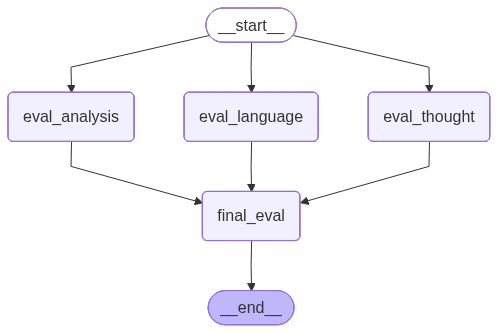

In [35]:
workflow

In [37]:
INITIAL_STATE = {
    'essay': essay
}

workflow.invoke(INITIAL_STATE)

{'essay': 'Role of AI in Modern Education\n\nThere is no denying that Artificial Intelligence (AI) has become an integral part of our daily lives, transforming various sectors including education. The integration of AI in modern education has brought about significant changes in the way students learn and teachers teach. AI-powered tools and platforms have made personalized learning a reality, allowing students to learn at their own pace and style. Intelligent tutoring systems can adapt to the individual needs of students, providing customized feedback and resources\n\n',
 'language_fdb': 'The language quality of this essay snippet is excellent. The writing is clear, concise, and grammatically sound. The vocabulary used is appropriate and precise, effectively conveying the ideas without being overly complex. Sentence structures are varied and contribute to a smooth flow of information. The introduction is strong, immediately establishing the topic and its significance. There are no not